Data Science Project: Developments in Homelessness in LA 2017-2019

In [1]:
import intake
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Creating a catalog based upon my shapefile databases. My data sources include:
1. Homelessness Counts by Council for 2017
2. Homelessness Counts by Council for 2018
3. Homelessness Counts by Council for 2019
4. Locations of Homeless Shelters in LA County
5. Border of LA County
6. Border of LA City
7. Boundaries of 15 Council Districts in LA
8. Census Data from 2010

In [2]:
catalog = intake.open_catalog('homeless.yml') #reading in new YAML file with updated data
print(list(catalog))

['homeless_2017', 'homeless_2018', 'homeless_2019', 'homeless_shelters', 'la_city', 'la_county', 'council_districts', 'census_data']


# Analysis Part 1 #

From my catalog, I can create dataframes for each of my different datasets and then use Pandas to analyze these.

In [3]:
year_one = catalog.homeless_2017.read()
year_two = catalog.homeless_2018.read()
year_three = catalog.homeless_2019.read()
shelters = catalog.homeless_shelters.read()
la_county = catalog.la_county.read()
la_city = catalog.la_city.read()
council_districts = catalog.council_districts.read()

After creating dataframes, I initially create a baseline visualization to see if there are any generally noticeable problems or findings within my data.

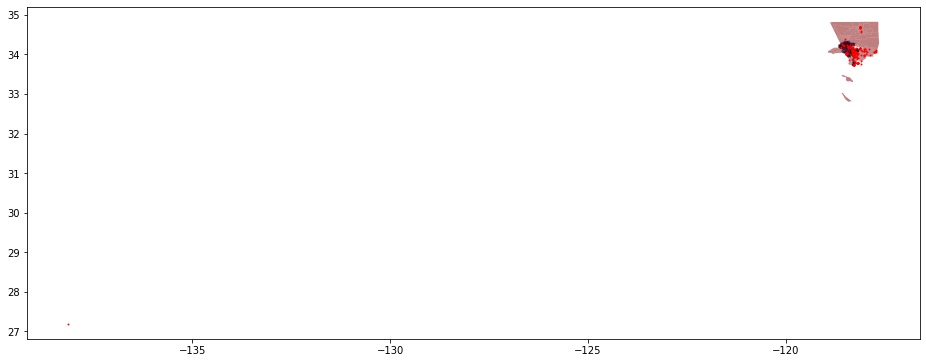

In [4]:
fig, ax = plt.subplots(1, figsize=(16,16))
year_one.plot(ax=ax, color='darkgreen', alpha=0.2, linewidth=1, edgecolor='black')
year_two.plot(ax=ax, color='navy', alpha=0.5, linewidth=1)
year_three.plot(ax=ax, color='maroon', alpha=0.5, linewidth=1)
shelters.plot(ax=ax, color = 'red', alpha = 0.9, markersize = 1)

As can be seen, the graph is very skewed. The reason for this is the outlier observation in the bottom left corner of the viz. The data for this shelter must have been entered incorrectly since it doesn't seem feasible to have a shelter in the middle of the ocean. With this in mind, I will later run a filter on my shelters dataframe that creates a boundary for just LA county, allowing me to continue without having to specifically edit my data manually. 

One way of doing this is simply running a command that only looks at observations with a latitude or longitude that matches more closely the lats and longs of LA county. This is a simple and quick fix. Another option would be to create a boundary using a geopandas dataframe, but for now this will do. I will create the boundary in a later step.

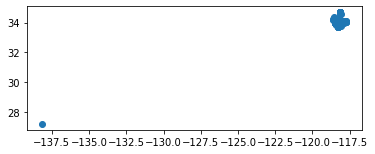

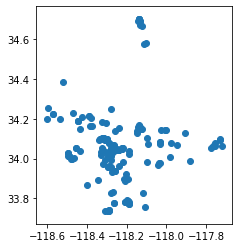

In [5]:
shelters_filtered = shelters[shelters['latitude'] >=30]
shelters.plot()
shelters_filtered.plot()

Running a filter that requires a latitude of greater than 30, even though it isn't the specific border of LA County, removes the outlier shelter and allows me to narrow my observations down to what I'm actually interested in. Creating another plot of my data but with the filtered shelters data should fix my proportion issues.

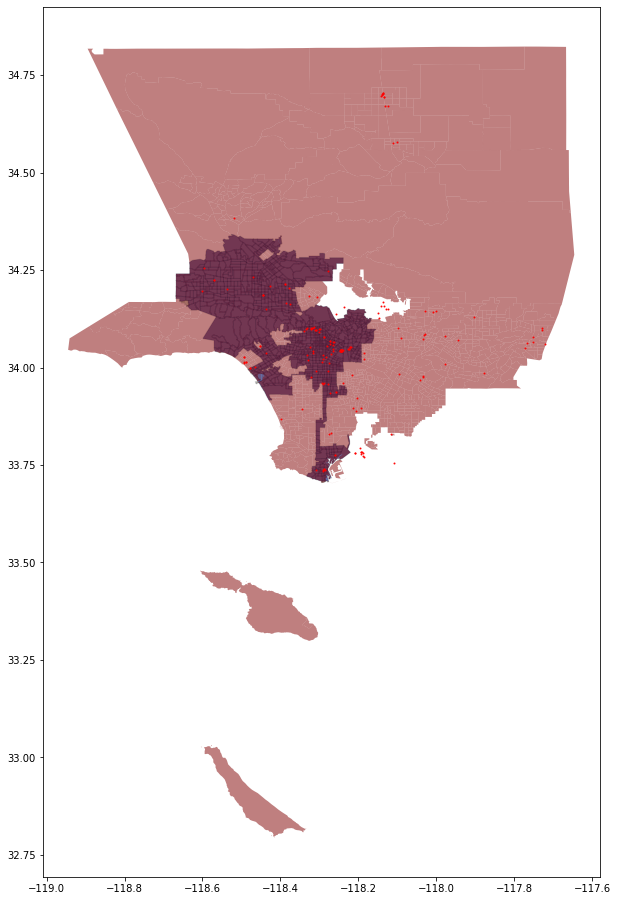

In [6]:
fig, ax = plt.subplots(1, figsize=(16,16))
year_one.plot(ax=ax, color='darkgreen', alpha=0.2, linewidth=1, edgecolor='black')
year_two.plot(ax=ax, color='navy', alpha=0.5, linewidth=1)
year_three.plot(ax=ax, color='maroon', alpha=0.5, linewidth=1)
shelters_filtered.plot(ax=ax, color = 'red', alpha = 0.9, markersize = 1)

Looking at my data now, I can see that LA County is large and it is hard to identify more closely specific areas in LA City that might be experiencing larger numbers of homelessness. To parse my data on a more individual level, I will filter my datasets according to Council District. Looking at the 15 CD's in LA City will give a more granular perspective on homelessness.

To filter datasets according to CD, it's best to use a dictionary. Dictionaries allow me to define items and actually call upon them easily, something that is more difficult in an array. With 3 years of data for 15 CDs, I can create three dictionaries, one for each year, that store data for each council district. I can then easily extract the data for each council district by using my key.

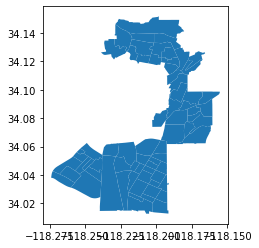

In [7]:
#2017
districts_2017 = {}
for x in year_one['CD'].unique():
    key = f"CD{x}"
    districts_2017[key] = year_one[year_one['CD'] == x]
#CD14 Example
districts_2017['CD14'].plot()

#2018
districts_2018 = {}
for x in year_two['CD'].unique():
    key = f"CD{x}"
    districts_2018[key] = year_two[year_two['CD'] == x]

#2019
districts_2019 = {}
for x in year_three['CD'].unique():
    key = f"CD{x}"
    districts_2019[key] = year_three[year_three['CD'] == x]

With data on a Council District level, I chose to do a few things. First, I chose to create another dictionary that stores the boundary coordinates for each of the 15 Council Districts. Second, I chose to plot those boundaries. Third, since the homelessness data is based on Census Tract Number, within each Council District I can plot the number of homeless who are unsheltered as a percentage of total homeless for a specific Census Tract. Finally, with the percentage of unsheltered homeless individuals within a Census Tract for a specific Council District, I can plot my findings. Matplotlib allows me to create a color filter to visually show the differences in unsheltered percentage that makes my graph more understandable. Additionally, I called upon my dictionary with Council District boundary coordinates to plot where homeless shelters are for specific council districts.

In [8]:
#Creating dictionary for council district boundaries
council_districts_boundaries = {}
for x in range(1, 16):
    key = f"CD{x}"
    council_districts_boundaries[key] = council_districts[council_districts['District'] == x]

Enter Council District Number: 14


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

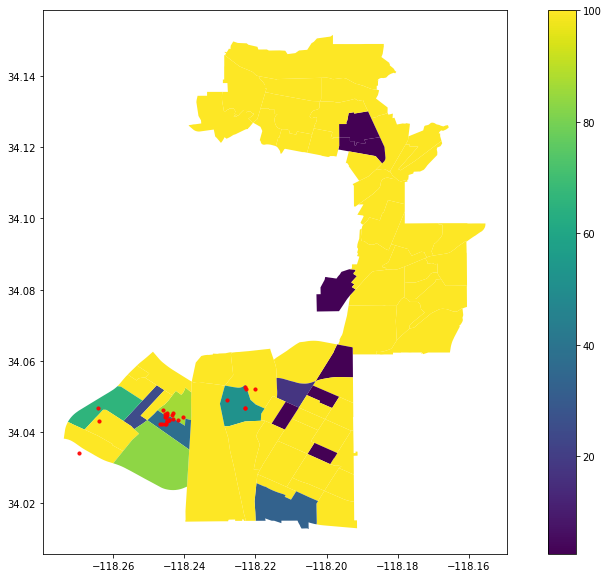

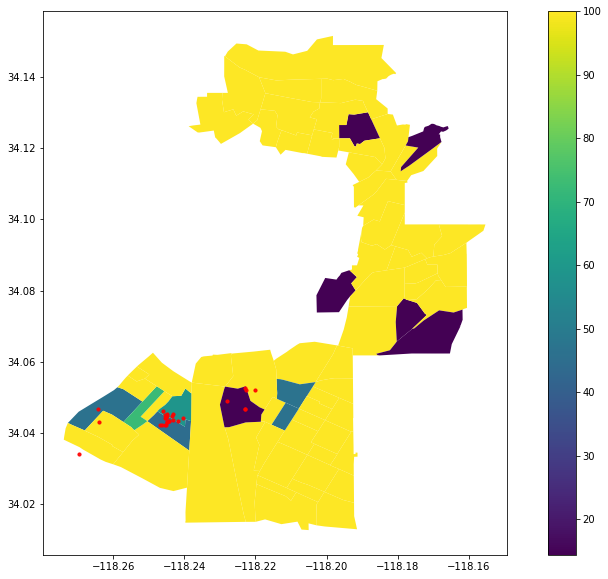

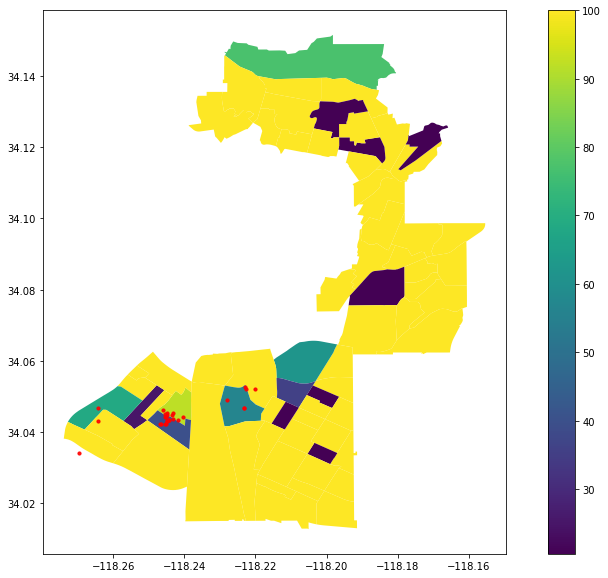

In [9]:
#User input to determine which Council District's data is visualized
council = input ("Enter Council District Number:")
council_boundary = council_districts_boundaries['CD'+ council].iloc[0].geometry
council_shelters = shelters_filtered[shelters_filtered.geometry.within(council_boundary)]

#2017: Number of those unsheltered as a percentage of all homeless in the CD
unsheltered_CD_2017 = districts_2017['CD'+ council]
unsheltered_proportion_2017 = (unsheltered_CD_2017['totUnshelt']/unsheltered_CD_2017['totPeople'])*100
unsheltered_CD_2017['Percent_Unsheltered'] = unsheltered_proportion_2017

fig, ax = plt.subplots(figsize=(15, 10))
unsheltered_CD_2017.plot(column='Percent_Unsheltered',ax=ax, legend=True)
council_shelters.plot(ax=ax, color = 'red', alpha = 0.9, markersize = 10)

#2018: Number of those unsheltered as a percentage of all homeless in the CD
unsheltered_CD_2018 = districts_2018['CD'+ council]
unsheltered_proportion_2018 = (unsheltered_CD_2018['totUnshelt']/unsheltered_CD_2018['totPeople'])*100
unsheltered_CD_2018['Percent_Unsheltered'] = unsheltered_proportion_2018

fig, ax = plt.subplots(figsize=(15, 10))
unsheltered_CD_2018.plot(column='Percent_Unsheltered',ax=ax, legend=True)
council_shelters.plot(ax=ax, color = 'red', alpha = 0.9, markersize = 10)

#2019: Number of those unsheltered as a percentage of all homeless in the CD
unsheltered_CD_2019 = districts_2019['CD' + council]
unsheltered_proportion_2019 = (unsheltered_CD_2019['totUnshe_1']/unsheltered_CD_2019['totPeopl_1'])*100
unsheltered_CD_2019['Percent_Unsheltered'] = unsheltered_proportion_2019

fig, ax = plt.subplots(figsize=(15, 10))
unsheltered_CD_2019.plot(column='Percent_Unsheltered',ax=ax, legend=True)
council_shelters.plot(ax=ax, color = 'red', alpha = 0.9, markersize = 10)

## Analysis Part 2: ##

In addition to understanding on a Council District level how many homeless individuals are unsheltered, it is useful to understand how many individuals in a Council District are homeless in comparison to total population. Since the homelessness datasets alone only account for total number of those who are homeless, we need to add in another dataset that gives us the necessary total population metric. The Census is a great way to get data on this info. 

Merging the Census data with the homeless data is my next stpe. However, the Census and the homelessness datasets don't match up perfectly and some of the datatypes are incompatable, making the merge process difficult. To avoid running into issues, I first cast my desired column, Tract Number, in my Census data as an int.

In [10]:
census_data = catalog.census_data.read()
census_data['TRACTCE10']=census_data['TRACTCE10'].astype(int)
census_data.head()

OBJECTID  TRACTCE10   POP  LATPOP_D  WHIPOP_D  BLAPOP_D  AMIPOP_D  \
0         1     101110  4731      1324      2656        83        24   
1         2     101122  3664       575      2437        34        18   
2         3     101210  5990      2219      2890       192        16   
3         4     101220  3363      1272      1662        45        25   
4         5     101300  4199       503      3190        47        26   

   ASIPOP_D  HPIPOP_D  OTHPOP_D  ...  ASIVAP_D  HPIVAP_D  OTHVAP_D  MMRVAP_D  \
0       580        15        37  ...       466        14        27         9   
1       578         3        12  ...       481         2        10         7   
2       625        16        15  ...       537        13        11        12   
3       335         6         6  ...       270         6         4         7   
4       402        10        10  ...       329         9         9         8   

   H0010001  H0010002  H0010003                                 TOOLTIP  \
0      1734      1641        93  Tract: 1011.10\nTotal Population: 4731   
1      1369      1325        44  Tract: 1011.22\nTotal Population: 3664   
2      2317      2150       167  Tract: 1012.10\nTotal Population: 5990   
3      1317      1246        71  Tract: 1012.20\nTotal Population: 3363   
4      1582      1542        40  Tract: 1013.00\nTotal Population: 4199   

                                             NLA_URL  \
0  navigatela/reports/census_tracts_2010.cfm?PK=1...   
1  navigatela/reports/census_tracts_2010.cfm?PK=1...   
2  navigatela/reports/census_tracts_2010.cfm?PK=1...   
3  navigatela/reports/census_tracts_2010.cfm?PK=1...   
4  navigatela/reports/census_tracts_2010.cfm?PK=1...   

                                            geometry  
0  POLYGON ((-118.2942041566864 34.26289090945109...  
1  POLYGON ((-118.2899581573591 34.27813191171668...  
2  POLYGON ((-118.2921191550502 34.25071190884022...  
3  POLYGON ((-118.2794601523556 34.2475709084817,...  
4  POLYGON ((-118.2654201515742 34.25546591096638...  

[5 rows x 26 columns]

With compatable data types, I can merge the two datasets on that column since all my datasets have a unique Tract Number associated with each observation. Merging these datasets will give each of my observations a new column of total population, thus allowing me to then work on determining overall levels of homelessness in comparison to population.

In [11]:
#2017
total_population_2017 = year_one.merge(census_data, left_on='Tract', right_on='TRACTCE10').set_geometry('geometry_y')

#2018
total_population_2018 = year_two.merge(census_data, left_on='Tract_N', right_on='TRACTCE10').set_geometry('geometry_y')

#2019
total_population_2019 = year_three.merge(census_data, left_on='Tract_N', right_on='TRACTCE10').set_geometry('geometry_y')

To get my percentage of homelessness to total population, I chose to create a function that divides total homeless population by the total overall population for each census tract. I included exceptions in the case that the total population is less than or equal to 0 or the total number of homeless people is greater than the overall number of the population so that my function doesn't break.

In [12]:
def percent_homeless (row):
    if row.POP <= 0 or row.totPeople > row.POP:
        return 0
    return (row.totPeople / row.POP)* 100

In [13]:
def percent_homeless_2019 (row):
    if row.POP <= 0 or row.totPeopl_1 > row.POP:
        return 0
    return (row.totPeopl_1 / row.POP)* 100

My `percent_homeless` and `percent_homeless_2019` functions essentially create an output that can be appended tomy merged dataframes in the form of a new column. I add these new columns to my dataframes for each year and title them 'Percent_Unsheltered'.

In [14]:
total_population_2017['Percent_Unsheltered'] = total_population_2017.apply(percent_homeless, axis=1)
total_population_2018['Percent_Unsheltered'] = total_population_2018.apply(percent_homeless, axis=1)
total_population_2019['Percent_Unsheltered'] = total_population_2019.apply(percent_homeless_2019, axis=1)

As I have done before with creating dictionaries for council boundaries and council district specific-data, I similarly create more dictionaries here so I can withdraw data from specific council districts. The reason I do this again here is because I now have a new dataframe associated with the total percentage of homelessness in an area so I need to add this info to my dictionaries.

In [15]:
totpop_CD_2017 = {}
for x in range(1, 16):
    key = f"CD{x}"
    totpop_CD_2017[key] = total_population_2017[total_population_2017['CD'] == x]
    
totpop_CD_2018 = {}
for x in range(1, 16):
    key = f"CD{x}"
    totpop_CD_2018[key] = total_population_2018[total_population_2018['CD'] == x]
    
totpop_CD_2019 = {}
for x in range(1, 16):
    key = f"CD{x}"
    totpop_CD_2019[key] = total_population_2019[total_population_2019['CD'] == x]

With my dictionaries, I can now map my data according to my council district of interest. 

Enter Council District Number: 14


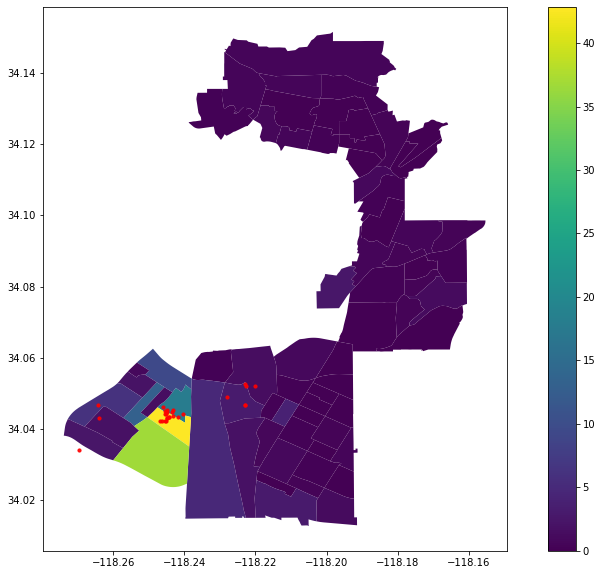

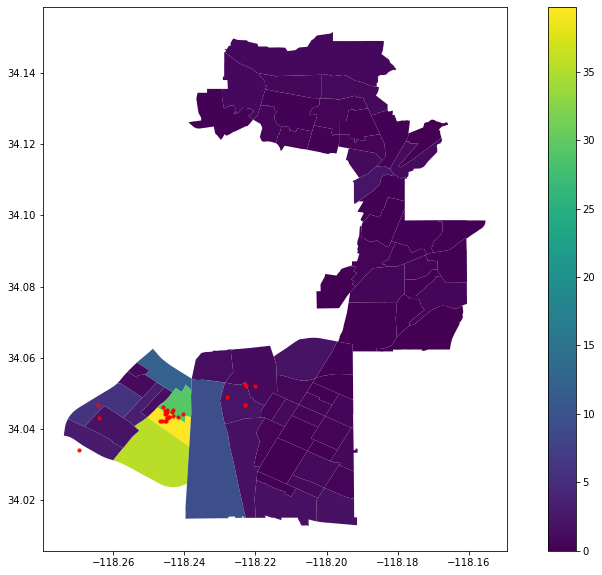

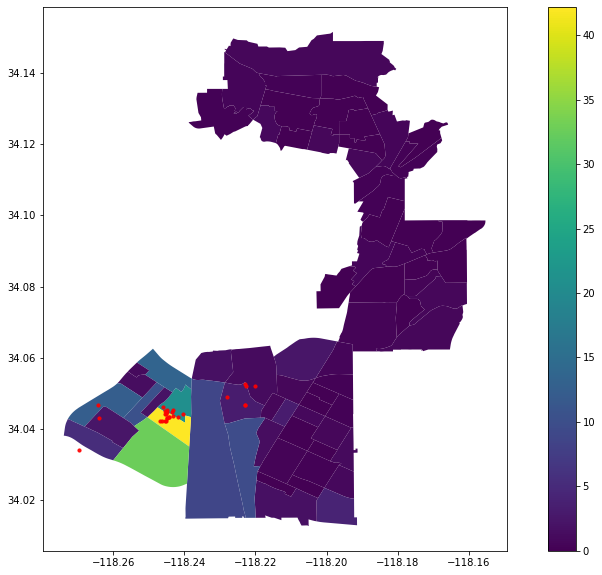

In [16]:
council = input ("Enter Council District Number:")
council_boundary = council_districts_boundaries['CD' + council].iloc[0].geometry
council_shelters = shelters_filtered[shelters_filtered.geometry.within(council_boundary)] 

#2017
tot_pop_CD_1 = totpop_CD_2017['CD'+ council]

fig, ax = plt.subplots(figsize=(15, 10))
tot_pop_CD_1.plot('Percent_Unsheltered',ax=ax, legend=True)
council_shelters.plot(ax=ax, color = 'red', alpha = 0.9, markersize = 10)

#2018
tot_pop_CD_2 = totpop_CD_2018['CD'+ council]

fig, ax = plt.subplots(figsize=(15, 10))
tot_pop_CD_2.plot('Percent_Unsheltered',ax=ax, legend=True)
council_shelters.plot(ax=ax, color = 'red', alpha = 0.9, markersize = 10)

#2019
tot_pop_CD_3 = totpop_CD_2019['CD'+ council]

fig, ax = plt.subplots(figsize=(15, 10))
tot_pop_CD_3.plot('Percent_Unsheltered',ax=ax, legend=True)
council_shelters.plot(ax=ax, color = 'red', alpha = 0.9, markersize = 10)

# Analysis Part 3 #

Now: I want to work on charting out how the percentages have changed over time. Maybe highlight places with a larger amount of change than average. To start this, I will first calculate the total percentage of homelessness in the city for 2017, 2018, and 2019, respectively.

In [17]:
#Across the City Average of Homelessness percentage for 2017
year_one_people = total_population_2017['totPeople'].sum()
year_one_population = total_population_2017['POP'].sum()
year_one_avg = (year_one_people / year_one_population) * 100

#Across the City Average of Homelessness percentage for 2018
year_two_people = total_population_2018['totPeople'].sum()
year_two_population = total_population_2018['POP'].sum()
year_two_avg = (year_two_people / year_two_population) * 100

#Across the City Average of Homelessness percentage for 2019
year_three_people = total_population_2019['totPeopl_1'].sum()
year_three_population = total_population_2019['POP'].sum()
year_three_avg = (year_three_people / year_three_population) * 100

In [18]:
year_one_avg

0.8215625076675118

In [19]:
year_two_avg

0.75060607971363

In [20]:
year_three_avg

0.8811091063409712

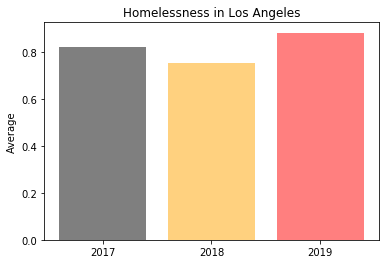

In [21]:
objects = (year_one_avg, year_two_avg, year_three_avg)
years = ['2017', '2018', '2019']
y_pos = np.arange(len(objects))

plt.bar(y_pos, objects, align='center', alpha=0.5,color=['Black', 'Orange', 'Red'])
plt.xticks(y_pos, years)
plt.ylabel('Average')
#plt.xlabel('2017', '2018', '2019')
plt.title('Homelessness in Los Angeles')

plt.show()

Here I calculate the average of homeless levels per county for each year per council district. I add the info I'm looking for into a dictionary, like I have done before, in order to organize my data. My dictionary is called `council_average`.

In [22]:
from pandas import DataFrame as df
#Council District Level Homelessness Averages

council_average={}

for x in range(1,16):
    key = f"Average_CD{x}"
    tot_pop_CD_1 = totpop_CD_2017['CD' + str(x)]
    CD_2017_people = tot_pop_CD_1['totPeople'].sum()
    CD_2017_population = tot_pop_CD_1['POP'].sum()
    council_average_2017 = (CD_2017_people / CD_2017_population) * 100

    #2018
    tot_pop_CD_2 = totpop_CD_2018['CD' + str(x)]
    CD_2018_people = tot_pop_CD_2['totPeople'].sum()
    CD_2018_population = tot_pop_CD_2['POP'].sum()
    council_average_2018 = (CD_2018_people / CD_2018_population) * 100

    #2019
    tot_pop_CD_3 = totpop_CD_2019['CD' + str(x)]
    CD_2019_people = tot_pop_CD_3['totPeopl_1'].sum()
    CD_2019_population = tot_pop_CD_3['POP'].sum()
    council_average_2019 = (CD_2019_people / CD_2019_population) * 100
    
    council_average[key] = {'CD':x,'2017 Avg.': council_average_2017, '2018 Avg.': council_average_2018, '2019 Avg.': council_average_2019}

council_average['Average_CD15']

{'CD': 15,
 '2017 Avg.': 0.8547234559557143,
 '2018 Avg.': 0.6064087090856426,
 '2019 Avg.': 0.8575681503652923}

With my dictionary, I cannot necessarily easily plot my findings. To get a plottable format, I can convert my dictionary to a pandas dataframe. Initially, my converted dataframe was essentially flipped on its diagonal axis where my columns were my rows and my rows were my columns. To fix this, I transposed my dataframe.

In [23]:
s = pd.DataFrame(council_average)
cd_averages = s.transpose()
cd_averages

2017 Avg.  2018 Avg.  2019 Avg.    CD
Average_CD1    1.023272   0.967808   1.179131   1.0
Average_CD2    0.398032   0.473434   0.644739   2.0
Average_CD3    0.229114   0.218988   0.246836   3.0
Average_CD4    0.286524   0.263506   0.390722   4.0
Average_CD5    0.368044   0.265778   0.364874   5.0
Average_CD6    0.762411   1.019157   0.759034   6.0
Average_CD7    0.468181   0.485670   0.498866   7.0
Average_CD8    0.862062   0.751596   0.888948   8.0
Average_CD9    1.395193   1.020949   1.408219   9.0
Average_CD10   0.520237   0.452842   0.476684  10.0
Average_CD11   1.007662   0.752973   0.898404  11.0
Average_CD12   0.326660   0.221225   0.190498  12.0
Average_CD13   1.108491   1.084970   1.261071  13.0
Average_CD14   2.723908   2.679234   2.984065  14.0
Average_CD15   0.854723   0.606409   0.857568  15.0

With the averages for each council district for 2017, 2018, and 2019, I can then calculate the percentage change in the averages over time. This isn't necessarily the same as the percentage increase in homelessness between years, but it does give a similar idea. (Tomorrow's work: find an change in homelessness as a percentage by using the real numbers (tot homeless vs tot pop for 2019 as compared to tot homeless vs tot pop for 2017 and 2018)

In [24]:
cd_averages['2017-9 Pct. Change'] = ((cd_averages['2019 Avg.'] - cd_averages['2017 Avg.']) / cd_averages['2017 Avg.']) * 100
cd_averages['2018-9 Pct. Change'] = ((cd_averages['2019 Avg.'] - cd_averages['2018 Avg.']) / cd_averages['2018 Avg.']) * 100
cd_averages['CD'] = cd_averages['CD'].astype(int)

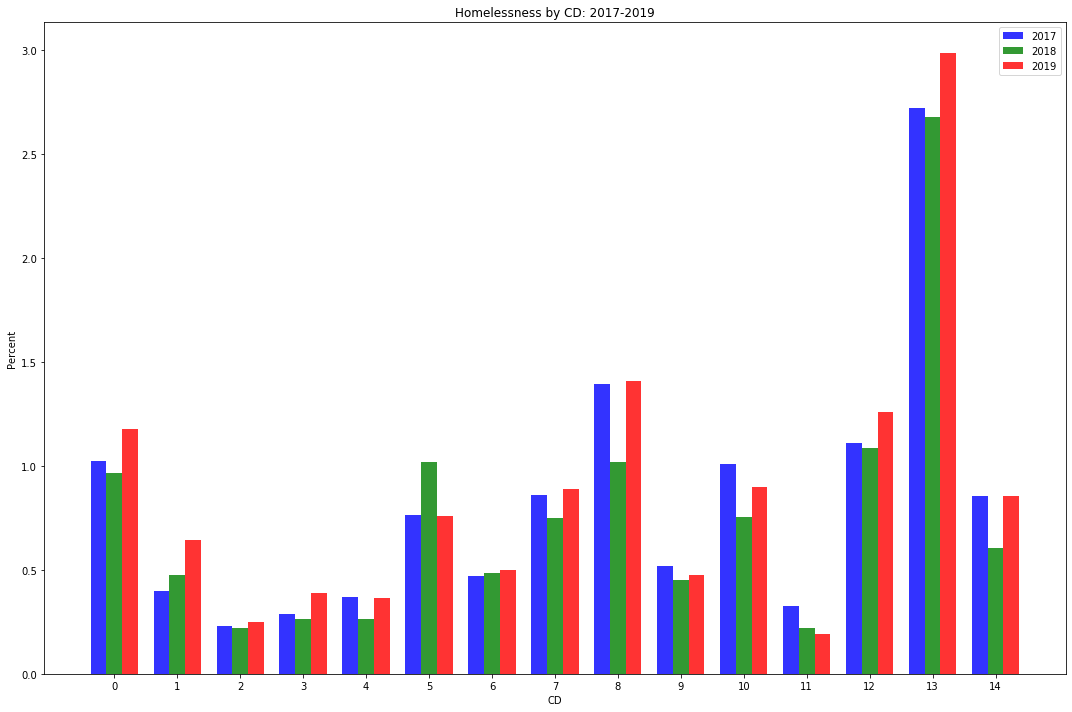

In [34]:
# data to plot

# create plot
fig, ax = plt.subplots(figsize=(15, 10))
index = np.arange(len(cd_averages['CD']))
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index - bar_width, cd_averages['2017 Avg.'], bar_width,
alpha=opacity,
color='b',
label='2017')

rects2 = plt.bar(index, cd_averages['2018 Avg.'], bar_width,
alpha=opacity,
color='g',
label='2018')

rects3 = plt.bar(index + bar_width, cd_averages['2019 Avg.'], bar_width,
alpha=opacity,
color='r',
label='2019')


plt.xlabel('CD')
plt.ylabel('Percent')
plt.title('Homelessness by CD: 2017-2019')
plt.xticks(index)
plt.legend()

plt.tight_layout()
plt.show()

More analysis to follow.